In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [6]:
from skimage.io import imread
import os
import pandas as pd

In [3]:
import importlib
import torch.utils.data
import functools
from torch.nn import init
import random
import itertools

import time
from tqdm import tqdm
from collections import OrderedDict, defaultdict

from PIL import Image

In [60]:
class CycleGANDataset(Dataset):
    def __init__(self, first_df, second_df, max_dataset_size=float("inf"), device='cpu'):
        self.device = device
        
        self.first_df = first_df
        self.second_df = second_df
        self.A_size = len(self.first_df)  # get the size of dataset A
        self.B_size = len(self.second_df)  # get the size of dataset B
        assert self.A_size == self.B_size
        
#         self.transform = get_transform()
        self.serial_batches = True
        
        self.items = []
        for idx in range(max(self.A_size, self.B_size)):
            self.items.append(self._get_item(idx))
    
    def _image_from_row(self, row):
        img = np.array(row).reshape((28, 28)).T
        img = torch.tensor(img).unsqueeze(0).type(torch.float).to(self.device)
        return img
        
    def _get_item(self, index):
        row_A = self.first_df.iloc[index]
        cls_A, img_A = row_A[0], row_A[1:]
        img_A = self._image_from_row(img_A)
        row_B = self.second_df.iloc[index]
        cls_B, img_B = row_B[0], row_B[1:]
        img_B = self._image_from_row(img_B)
        
        # TODO: to tensor & to device

        return {'A': img_A, 'B': img_B}
    
    def __getitem__(self, index):
        return self.items[index]

    def __len__(self):
        """Return the total number of images in the dataset.
        As we have two datasets with potentially different number of images,
        we take a maximum of
        """
        return max(self.A_size, self.B_size)

In [38]:
path_to_data = '../data/thedataset/version1.csv'
df = pd.read_csv(path_to_data, header=None)

In [39]:
class_mapping = {
    'o' : 15,
    'u' : 21,
    'o:' : 31,
    'u:' : 32,
}

first_group = ['o', 'u']
second_group = ['o:', 'u:']
first_indices = [class_mapping[cls] for cls in first_group]
second_indices = [class_mapping[cls] for cls in second_group]

In [40]:
first_df = df[df[0].isin(first_indices)].sample(frac=1).reset_index(drop=True)
second_df = df[df[0].isin(second_indices)].sample(frac=1).reset_index(drop=True)

In [61]:
dataset = CycleGANDataset(first_df, second_df, device=f'cuda:0')

Датасет создали.

Источник кода ниже:

https://github.com/junyanz/CycleGAN

In [42]:
def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x):
            return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

In [43]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [44]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [45]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

In [46]:
def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

In [47]:
def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator
    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Returns a generator
    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597
        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).
    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


In [48]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [49]:
def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator
    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Returns a discriminator
    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.
        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)
        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.
    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)

In [50]:
class ImagePool():
    """This class implements an image buffer that stores previously generated images.
    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class
        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.
        Parameters:
            images: the latest generated images from the generator
        Returns images from the buffer.
        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [51]:
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


In [52]:
def get_scheduler(optimizer, epoch_count, lr_policy='linear', n_epochs=100, n_epochs_decay=100, lr_decay_iters=50):
    """Return a learning rate scheduler
    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine
    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + epoch_count - n_epochs) / float(n_epochs_decay + 1)
            return lr_l
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

In [53]:
class CycleGANModel:
    def __init__(self, gpu_ids):
        self.gpu_ids = gpu_ids
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        
        norm = 'instance'
        pool_size = 50
        lr=0.0002
        beta1=0.5
        
        net_G = 'resnet_6blocks'
        
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        
        
        self.netG_A = define_G(input_nc=1,
                                         output_nc=1,
                                         ngf=64,
                                         netG=net_G,
                                         norm=norm,
                                         use_dropout=True,
                                         init_type='normal',
                                         init_gain=0.02,
                                         gpu_ids=self.gpu_ids)
        self.netG_B = define_G(input_nc=1,
                                         output_nc=1,
                                         ngf=64,
                                         netG=net_G,
                                         norm=norm,
                                         use_dropout=True,
                                         init_type='normal',
                                         init_gain=0.02,
                                         gpu_ids=self.gpu_ids)
        
        self.netD_A = define_D(input_nc=1,
                                        ndf=64,
                                        netD='basic',
                                        n_layers_D=3, # does not matter
                                        norm=norm,
                                        init_type='normal',
                                        init_gain=0.02,
                                        gpu_ids=self.gpu_ids)
        self.netD_B = define_D(input_nc=1,
                                        ndf=64,
                                        netD='basic',
                                        n_layers_D=3, # does not matter
                                        norm=norm,
                                        init_type='normal',
                                        init_gain=0.02,
                                        gpu_ids=self.gpu_ids)
#         if opt.lambda_identity > 0.0:  # only works when input and output images have the same number of channels
#             assert 3 == 3

        self.fake_A_pool = ImagePool(pool_size)  # create image buffer to store previously generated images
        self.fake_B_pool = ImagePool(pool_size)  # create image buffer to store previously generated images
        # define loss functions
        self.criterionGAN = GANLoss(gan_mode='lsgan').to(self.device)  # define GAN loss.
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=lr, betas=(beta1, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=lr, betas=(beta1, 0.999))
        
        self.optimizers = []
        self.optimizers.append(self.optimizer_G)
        self.optimizers.append(self.optimizer_D)
        
    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): include the data itself and its metadata information.
        The option 'direction' can be used to swap domain A and domain B.
        """
#         self.real_A = input['A'].to(self.device)
#         self.real_B = input['B'].to(self.device)
        self.real_A = input['A']
        self.real_B = input['B']

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))
    
    def setup(self):
        self.schedulers = [get_scheduler(optimizer, epoch_count=0) for optimizer in self.optimizers]
    
    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad
    
    def update_learning_rate(self, print_lr=False):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        if print_lr:
            print('learning rate %.7f -> %.7f' % (old_lr, lr))
    
    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = 0.5
        lambda_A = 10.0
        lambda_B = 10.0
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()
    
    def backward_D_basic(self, netD, real, fake):
        """Calculate GAN loss for the discriminator
        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator
        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D
    
    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)
    
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights
    
    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret
    
    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = f'{epoch}_net_{name}.pth'
                save_path = os.path.join('models/', save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)
        

In [54]:
model = CycleGANModel([0])
model.setup()

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [55]:
def remove_data_by_epoch(epoch, d = 'models'):
    for file in os.listdir(d):
        if file.startswith(f'{epoch}_') and file.endswith('.pth'):
            os.remove(os.path.join(d, file))

In [56]:
def train(model, n_epoch):
    losses = defaultdict(list)
    for epoch in tqdm(range(n_epoch+1)):
#         epoch_start_time = time.time()
        model.update_learning_rate(print_lr=True)
        for i, data in enumerate(dataset):
            model.set_input(data)
            model.optimize_parameters()
#         print(epoch_start_time - time.time())
        loss = model.get_current_losses()
    
        clear_output()
        plt.figure(figsize=(15, 6))
        for item in loss:
            losses[item].append(loss[item])
            plt.plot(losses[item], label=item)
        plt.title('Loss')
        plt.legend(loc=1)
        plt.show()
        
        if epoch % 10 == 0:
            model.save_networks(epoch)
            torch.save(losses, f'{epoch}_losses.pth')
            remove_data_by_epoch(epoch-20)
    return losses

In [ ]:
n_epoch = 200
losses = train(model, n_epoch)

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

learning rate 0.0002000 -> 0.0002000


In [26]:
test_dataset = CycleGANDataset('apple2orange/test', device=f'cuda:{gpu_number}')

In [77]:
import warnings
warnings.filterwarnings('ignore')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


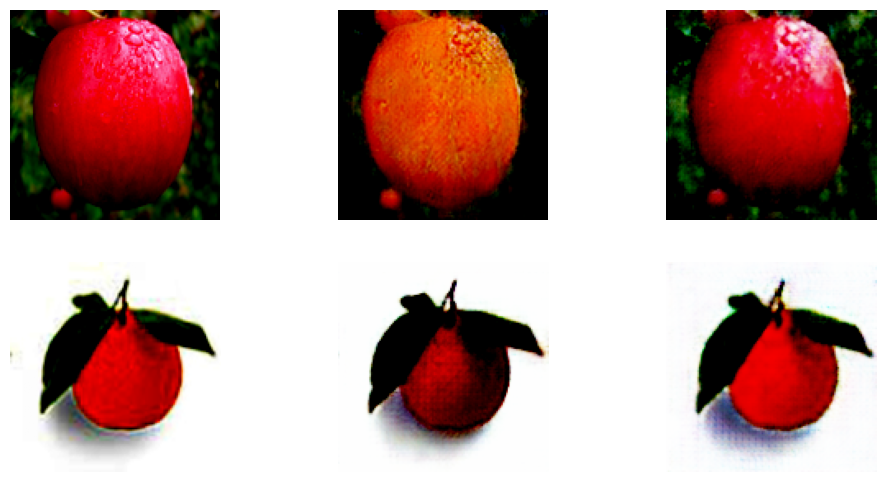

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


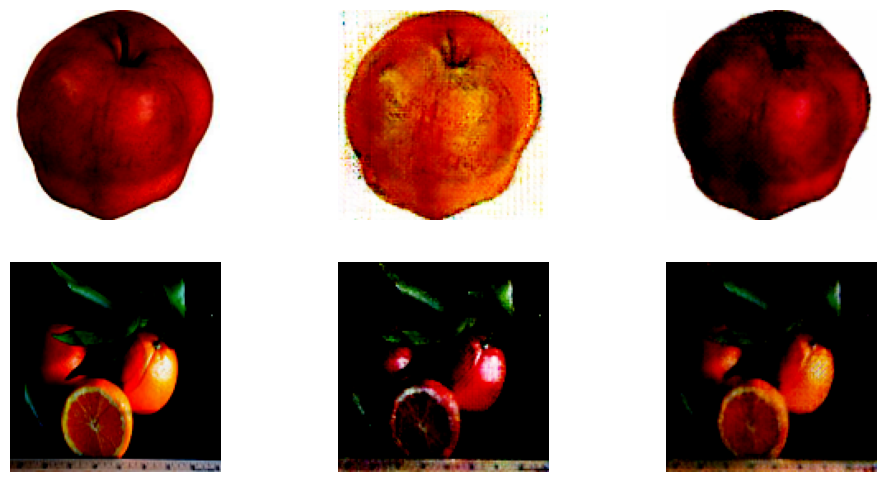

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


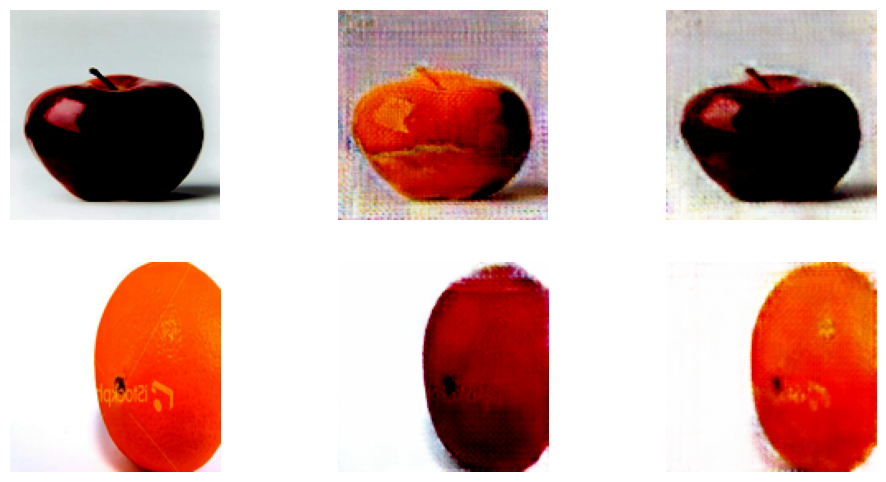

In [94]:
%matplotlib inline
for idx in [6, 7, 8]:
    model.set_input(test_dataset[idx])
    # Nice looking: 2, 5, 6
    model.forward()

    plt.figure(figsize=(12, 6))

    images = [model.real_A,
              model.fake_B,
              model.rec_A,

              model.real_B,
              model.fake_A,
              model.rec_B
             ]

    for i, image in enumerate(images):
        image = image.detach().cpu().permute(1, 2, 0)
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.axis('off')


    plt.show()

In [115]:
colors = defaultdict(lambda: sns.color_palette("muted")[len(colors)])

def get_params(name):
    loss = name[:name.find('_')]
    color = colors[loss]
    ls = '-' if name.endswith('A') else '-.'
    return {'color' : color, 'ls' : ls}

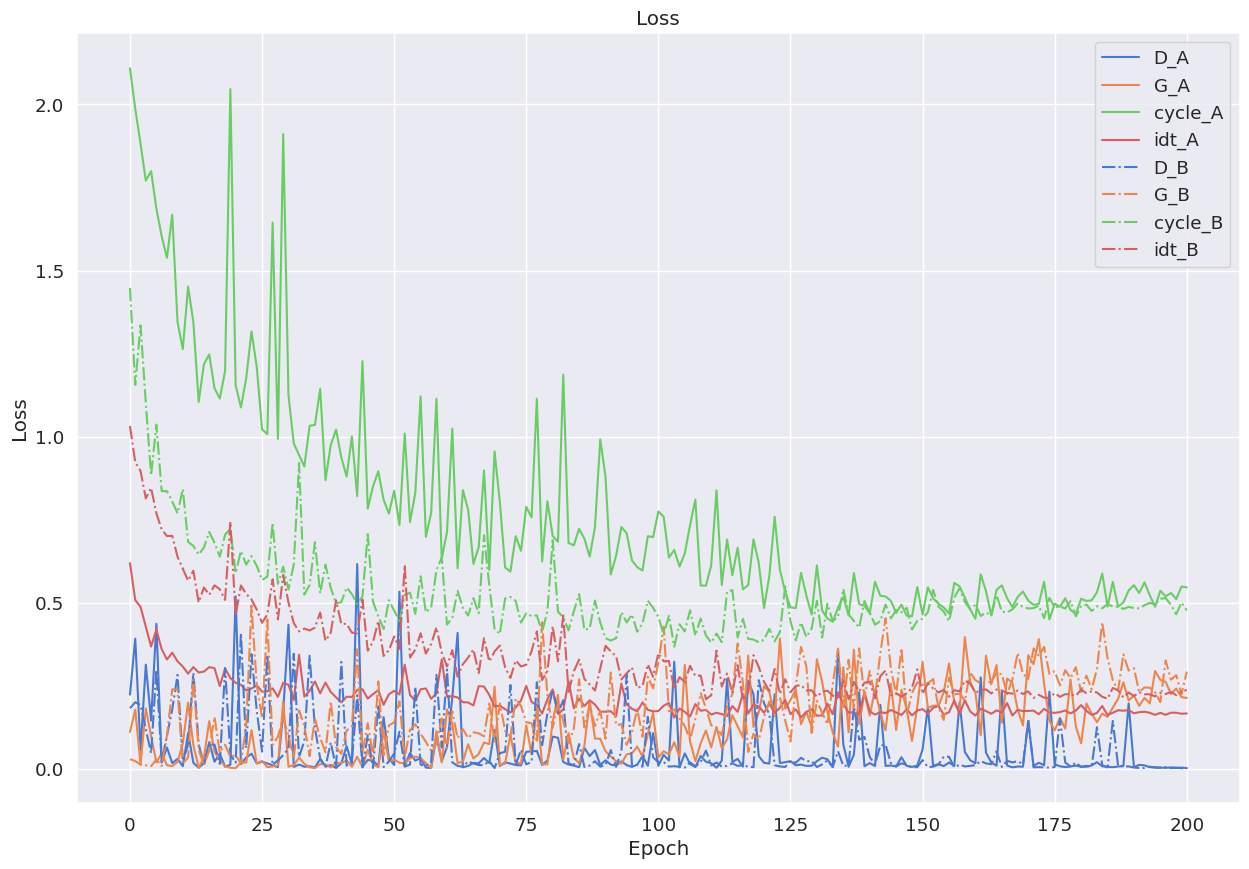

In [117]:
plt.figure(figsize=(15, 10))
for item in losses:
    plt.plot(losses[item], label=item, **get_params(item))
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.show()